In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Additional Feature Engineering

In addition to the above features, there are a few additional features that I'll create.

__Book features:__
* I'll use k-means clustering to group books into related clusters. These clusters will serve as their own feature, but they'll also help to create the second feature.
* Using cosine similarity based on book description, I'll create a list of the most similar books for each book. Then, using the top 3 most similar books, I'll create a feature for the average rating of each of these most similar books.

__Review features:__
* Using the clusters created above, I'll create a feature that is the average rating a user gives to books within that cluster. For example, if a specific review is for a book in cluster 2, an additional feature for that review will be the average rating that reader has given to other books in cluster 2.
* I'll use NLP to create a sentiment for each review, based on the text review. This will be either "postive", "neutral" or "negative."

## Book Features

### 1: Clusters

The first step is to use unsupervised learning to group books into clusters of the most similiar books.

In [4]:
books = pd.read_csv('../data/interim/books_step3_output.csv', index_col='book_id')
books.head()

,average_rating,similar_books,description,authors,num_pages,publication_year,ratings_count,title
book_id,,,,,,,,
13571772,4.28,"['13590139', '105963', '207585', '10503130', '...",The questions plaguing Captain America's dream...,['37450'],146,2012,51,Captain America: Winter Soldier (The Ultimate ...
35452242,4.05,[],The fight for Jason Delgado's life and soul be...,"['16209952', '853385']",160,2012,6,Bounty Hunter 4/3: My Life in Combat from Mari...
707611,4.06,[],These are the stories that catapulted Superman...,"['81563', '89537']",272,1997,51,"Superman Archives, Vol. 2"
27036536,4.15,[],PRODUCT DESCRIPTION: The first new volume of G...,"['14965', '3188368', '131836', '7507599']",224,2016,39,"War Stories, Volume 3"
11827783,3.16,"['6651573', '8835785', '15060759', '9466897', ...",Sir Arthur Conan Doyle's dauntless detective r...,"['61231', '4980321']",144,2011,114,Sherlock Holmes: Year One


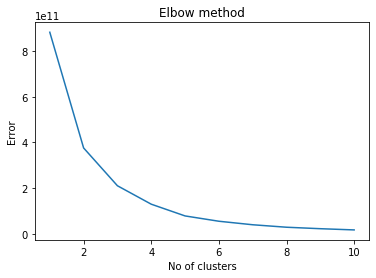

In [5]:
# Use elbow plot method to determine number of clusters to use
from sklearn.cluster import KMeans
x = books.drop(['description','title', 'similar_books','authors'], axis=1).values

Error = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(x)
    kmeans.fit(x)
    Error.append(kmeans.inertia_)

plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

Based on this, either 4 or 5 clusters seems about right. I'll use 5.

In [6]:
# create clusters and assign
kmeans5 = KMeans(n_clusters=5)
y_kmeans5 = kmeans5.fit_predict(x)

books['cluster'] = y_kmeans5
books.cluster.value_counts()

0    33048
4      747
2      103
1       26
3        1
Name: cluster, dtype: int64

### 2: Most Similar Books

In [7]:
# Create a similarity list of books based on descriptions
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
books['description'] = books['description'].fillna('')
tfidf_matrix = tfidf.fit_transform(books['description'])

In [8]:
# Use linear kernal to compute a cosine similarity score
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [9]:
# Create a reverse mapping index - this will be used to get the book_id, given a books place 
# in cosine_sim
indices = pd.Series(books.index)

In [10]:
# Create a function to take the index of a cosine_sim book, sort the enumerated scores for that
# book as a list of tuples. Then lookup the book_id for the top books, using the indices map.
# Then return the titles and average ratings for similiar books # 2 & 3 (ignore #1 bc it will b
# itself.)

def get_similar_ratings(index, cosine_sim=cosine_sim):
    # Get the pairwise similarity scores for all books with that book - use enumerate to keep
    # scores tied with index, for identification.
    sim_scores = list(enumerate(cosine_sim[index]))
    
    # Sort the books based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the top 3 most similar books, ignoring the first
    sim_scores = sim_scores[1:4]
    
    # Get the book_ids for those books
    book_ids = [i[0] for i in sim_scores]
    
    return books['average_rating'].iloc[book_ids]

In [11]:
# Create a list of average rating for the top 3 most similiar books for each book
books['top3_similar_ratings'] = [get_similar_ratings(x) for x in range(len(books))]

In [12]:
# Create functions to access the values from above

def get_first_rating(index):
    return books.top3_similar_ratings.iloc[index].iloc[0]

def get_second_rating(index):
    return books.top3_similar_ratings.iloc[index].iloc[1]

def get_third_rating(index):
    return books.top3_similar_ratings.iloc[index].iloc[2]

In [13]:
books['most_similar_book_avg_rtg'] = [get_first_rating(x) for x in range(len(books))]

In [14]:
books['2nd_similar_book_avg_rtg'] = [get_second_rating(x) for x in range(len(books))]

In [15]:
books['3rd_similar_book_avg_rtg'] = [get_third_rating(x) for x in range(len(books))]

In [16]:
display(books.head())

,average_rating,similar_books,description,authors,num_pages,publication_year,ratings_count,title,cluster,top3_similar_ratings,most_similar_book_avg_rtg,2nd_similar_book_avg_rtg,3rd_similar_book_avg_rtg
book_id,,,,,,,,,,,,,
13571772,4.28,"['13590139', '105963', '207585', '10503130', '...",The questions plaguing Captain America's dream...,['37450'],146,2012,51,Captain America: Winter Soldier (The Ultimate ...,0,book_id 106052 4.28 106041 4.28 1609...,4.28,4.28,4.32
35452242,4.05,[],The fight for Jason Delgado's life and soul be...,"['16209952', '853385']",160,2012,6,Bounty Hunter 4/3: My Life in Combat from Mari...,0,book_id 6420318 4.03 29214708 4.46 3596...,4.03,4.46,3.98
707611,4.06,[],These are the stories that catapulted Superman...,"['81563', '89537']",272,1997,51,"Superman Archives, Vol. 2",0,book_id 381244 4.00 707595 4.21 2424...,4.00,4.21,4.50
27036536,4.15,[],PRODUCT DESCRIPTION: The first new volume of G...,"['14965', '3188368', '131836', '7507599']",224,2016,39,"War Stories, Volume 3",0,book_id 448079 3.38 95405 3.91 674626...,3.38,3.91,4.18
11827783,3.16,"['6651573', '8835785', '15060759', '9466897', ...",Sir Arthur Conan Doyle's dauntless detective r...,"['61231', '4980321']",144,2011,114,Sherlock Holmes: Year One,0,book_id 17973194 3.72 6651573 4.04 8353...,3.72,4.04,3.78


In [17]:
books.to_csv('../data/interim/books_final.csv')

## Review Features

### 1: Review sentiment

For reviews, the first step is to create a sentiment rating for each review, based on the text of that review.

In [36]:
reviews = pd.read_csv('../data/interim/reviews_step3_output.csv', index_col='review_id')
reviews.drop('Unnamed: 0', axis=1, inplace=True)
reviews.head()

,user_id,book_id,rating,review_text
review_id,,,,
66b2ba840f9bd36d6d27f46136fe4772,dc3763cdb9b2cae805882878eebb6a32,18471619,3,Sherlock Holmes and the Vampires of London \n ...
72f1229aba5a88f9e72f0dcdc007dd22,bafc2d50014200cda7cb2b6acd60cd73,6315584,4,"I've never really liked Spider-Man. I am, howe..."
a75309355f8662caaa5e2c92ab693d3f,bafc2d50014200cda7cb2b6acd60cd73,29847729,4,"A very quick introduction, this is coming out ..."
c3cc5a3e1d6b6c9cf1c044f306c8e752,bafc2d50014200cda7cb2b6acd60cd73,18454118,5,I've been waiting so long for this. I first st...
cc444be37ab0a42bfb4dd818cb5edd10,bafc2d50014200cda7cb2b6acd60cd73,2239435,4,The only thing more entertaining than this boo...


In [19]:
# !pip install nltk
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mdurr\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Per the notes on this page: https://github.com/cjhutto/vaderSentiment#about-the-scoring, the typical thresholds for unidimensional measures of sentiment using this methodolgy are:

positive sentiment: compound score >= 0.05
neutral sentiment: score between -0.05 and 0.05
negative sentiment: score <= -0.05
So those are the thresholds I will use.

In [20]:
def get_sentiment(score):
    '''takes in a polarity score and returns a sentiment (pos, neu, neg) based on the thresholds
    above'''
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [37]:
# Need to drop reviews that are missing review_text
reviews.dropna(inplace=True)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 542015 entries, 66b2ba840f9bd36d6d27f46136fe4772 to 36a3f1c2fc2cfb96e70773106e158489
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      542015 non-null  object
 1   book_id      542015 non-null  int64 
 2   rating       542015 non-null  int64 
 3   review_text  542015 non-null  object
dtypes: int64(2), object(2)
memory usage: 20.7+ MB


In [31]:
# Create a list of polarity scores
sid = SentimentIntensityAnalyzer()
scores = [sid.polarity_scores(x)['compound'] for x in reviews.review_text.values]

In [38]:
# Create a column for review_sentiment based on those scores
reviews['review_sentiment'] = [get_sentiment(x) for x in scores]

In [39]:
reviews['review_sentiment'].value_counts()

positive    385222
negative     91619
neutral      65174
Name: review_sentiment, dtype: int64

### 2: Average rating by cluster

For each review, I'll create an additional feature for that reader's average rating for books in that cluster. This will require merging over the book cluster feature created above.

In [ ]:
reviews.set_index(['user_id','book_id'], inplace=True)

In [45]:
from tqdm import tqdm

clusters = []

for (x,y) in tqdm(reviews.index):
    try:
        clusters.append(books.loc[y]['cluster'])
    except:
        clusters.append(np.nan)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 542015/542015 [01:47<00:00, 5037.19it/s]


In [46]:
reviews['book_cluster'] = clusters
reviews.book_cluster.isnull().sum()

156455

In [47]:
reviews.dropna(inplace=True)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 385560 entries, ('dc3763cdb9b2cae805882878eebb6a32', 18471619) to ('bd575ed739592a8c20c346e5daa5ac76', 138398)
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rating            385560 non-null  int64  
 1   review_text       385560 non-null  object 
 2   review_sentiment  385560 non-null  object 
 3   book_cluster      385560 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 15.8+ MB


In [49]:
reviews.book_cluster.value_counts()

0.0    240804
4.0     84398
2.0     41391
1.0     17211
3.0      1756
Name: book_cluster, dtype: int64

In [60]:
# Group by cluster to get average rating by cluster
averages = reviews.groupby(['user_id','book_cluster'])['rating'].mean()

In [61]:
data = pd.merge(left=reviews, right=averages, on=['user_id', 'book_cluster'], how='left')
data.head()

,rating_x,review_text,review_sentiment,book_cluster,rating_y
user_id,,,,,
dc3763cdb9b2cae805882878eebb6a32,3,Sherlock Holmes and the Vampires of London \n ...,positive,0.0,3.000000
bafc2d50014200cda7cb2b6acd60cd73,4,"I've never really liked Spider-Man. I am, howe...",positive,0.0,4.285714
bafc2d50014200cda7cb2b6acd60cd73,4,"A very quick introduction, this is coming out ...",positive,0.0,4.285714
bafc2d50014200cda7cb2b6acd60cd73,5,I've been waiting so long for this. I first st...,positive,0.0,4.285714
bafc2d50014200cda7cb2b6acd60cd73,4,The only thing more entertaining than this boo...,positive,0.0,4.285714


In [62]:
reviews['avg_rating_by_cluster'] = data.rating_y.values
reviews.iloc[20:30]

rating  \
user_id                          book_id            
0d8d07544717e84149df654caae803d0 1146185        5   
                                 188172         5   
74923eed26118d852196f9aa18070272 27157815       5   
                                 18659623       4   
5e09e38e178edf7b524913c729854741 10630620       3   
617ccec66dac2d1029600ed3d706e8ed 18222546       5   
                                 9615347        4   
d4b1dcb35db677f20ee45225a5e43be2 18189479       3   
                                 17412749       4   
                                 11480909       4   

                                                                                 review_text  \
user_id                          book_id                                                       
0d8d07544717e84149df654caae803d0 1146185   Camelot 3000 was one of my favorite comics bac...   
                                 188172    This, to me, is one of the greatest graphic no...   
74923eed26118d852196f9aa18070272 27157815  Very unfortunate that these stories are true b...   
                                 18659623  I really enjoyed this collection of graphic sh...   
5e09e38e178edf7b524913c729854741 10630620  The graphics are excellent, but I felt cheated...   
617ccec66dac2d1029600ed3d706e8ed 18222546  I like it, I also liked the message never give...   
                                 9615347                                       I enjoyed it.   
d4b1dcb35db677f20ee45225a5e43be2 18189479     I wanted to like this so much more than I did.   
                                 17412749  4.5 stars. Absolutely beautiful art and a comp...   
                                 11480909  Beautiful, surreal manifestation of a more sob...   

                                          review_sentiment  book_cluster  \
user_id                          book_id                                   
0d8d07544717e84149df654caae803d0 1146185          positive           0.0   
                                 188172           positive           0.0   
74923eed26118d852196f9aa18070272 27157815         negative           0.0   
                                 18659623         positive           2.0   
5e09e38e178edf7b524913c729854741 10630620         positive           0.0   
617ccec66dac2d1029600ed3d706e8ed 18222546         positive           0.0   
                                 9615347          positive           2.0   
d4b1dcb35db677f20ee45225a5e43be2 18189479         positive           0.0   
                                 17412749         positive           0.0   
                                 11480909         positive           0.0   

                                           avg_rating_by_cluster  
user_id                          book_id                          
0d8d07544717e84149df654caae803d0 1146185                5.000000  
                                 188172                 5.000000  
74923eed26118d852196f9aa18070272 27157815               5.000000  
                                 18659623               4.000000  
5e09e38e178edf7b524913c729854741 10630620               3.000000  
617ccec66dac2d1029600ed3d706e8ed 18222546               5.000000  
                                 9615347                4.000000  
d4b1dcb35db677f20ee45225a5e43be2 18189479               3.571429  
                                 17412749               3.571429  
                                 11480909               3.571429

In [63]:
reviews.to_csv('../data/interim/reviews_final.csv')

# Combine Books & Reviews into Final Dataset

Now that I've cleaned and explored my datasets, time to combine them into my modelling data. Then create the last few features.

In [66]:
# Combine dataframes into one data set where each observation is a review
results = reviews.reset_index().merge(books, how='left', on='book_id').set_index(['user_id','book_id'])

In [67]:
display(results.head())
display(results.info())

rating  \
user_id                          book_id            
dc3763cdb9b2cae805882878eebb6a32 18471619       3   
bafc2d50014200cda7cb2b6acd60cd73 6315584        4   
                                 29847729       4   
                                 18454118       5   
                                 2239435        4   

                                                                                 review_text  \
user_id                          book_id                                                       
dc3763cdb9b2cae805882878eebb6a32 18471619  Sherlock Holmes and the Vampires of London \n ...   
bafc2d50014200cda7cb2b6acd60cd73 6315584   I've never really liked Spider-Man. I am, howe...   
                                 29847729  A very quick introduction, this is coming out ...   
                                 18454118  I've been waiting so long for this. I first st...   
                                 2239435   The only thing more entertaining than this boo...   

                                          review_sentiment  book_cluster  \
user_id                          book_id                                   
dc3763cdb9b2cae805882878eebb6a32 18471619         positive           0.0   
bafc2d50014200cda7cb2b6acd60cd73 6315584          positive           0.0   
                                 29847729         positive           0.0   
                                 18454118         positive           0.0   
                                 2239435          positive           0.0   

                                           avg_rating_by_cluster  \
user_id                          book_id                           
dc3763cdb9b2cae805882878eebb6a32 18471619               3.000000   
bafc2d50014200cda7cb2b6acd60cd73 6315584                4.285714   
                                 29847729               4.285714   
                                 18454118               4.285714   
                                 2239435                4.285714   

                                           average_rating  \
user_id                          book_id                    
dc3763cdb9b2cae805882878eebb6a32 18471619            3.26   
bafc2d50014200cda7cb2b6acd60cd73 6315584             4.07   
                                 29847729            4.17   
                                 18454118            4.07   
                                 2239435             3.20   

                                                                               similar_books  \
user_id                          book_id                                                       
dc3763cdb9b2cae805882878eebb6a32 18471619  ['10638896', '18124619', '2014491', '4523963',...   
bafc2d50014200cda7cb2b6acd60cd73 6315584   ['222298', '1056806', '267791', '95131', '3773...   
                                 29847729                                                 []   
                                 18454118                                                 []   
                                 2239435   ['11020991', '1149278', '106063', '4328865', '...   

                                                                                 description  \
user_id                          book_id                                                       
dc3763cdb9b2cae805882878eebb6a32 18471619  Sherlock Holmes died fighting Professor Moriar...   
bafc2d50014200cda7cb2b6acd60cd73 6315584   Peter Parker's life has hit a peaceful stretch...   
                                 29847729  Jim Butcher's worldwide bestselling Dresden Fi...   
                                 18454118  Yuto Lennix is a former investigator for the D...   
                                 2239435   The talents responsible for some of Batman's g...   

                                                                            authors  \
user_id                          book_id                                              
dc3763cdb9b2cae805882878eebb6a32 1847161

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 385560 entries, ('dc3763cdb9b2cae805882878eebb6a32', 18471619) to ('bd575ed739592a8c20c346e5daa5ac76', 138398)
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   rating                     385560 non-null  int64  
 1   review_text                385560 non-null  object 
 2   review_sentiment           385560 non-null  object 
 3   book_cluster               385560 non-null  float64
 4   avg_rating_by_cluster      385560 non-null  float64
 5   average_rating             385560 non-null  float64
 6   similar_books              385560 non-null  object 
 7   description                385560 non-null  object 
 8   authors                    385560 non-null  object 
 9   num_pages                  385560 non-null  int64  
 10  publication_year           385560 non-null  int64  
 11  ratings_count              385560 non-null  int64  
 12  tit

None

__Create categorical type for sentiment__
One last feature engineering step before preprocessing....turn review sentiment into a category.

In [70]:
results['review_sentiment'] = results['review_sentiment'].astype('category')

In [71]:
# Drop columns that were used for feature engineering and no longer needed
results.drop(['review_text','similar_books','description','authors','title',
              'top3_similar_ratings'], axis=1, inplace=True)
results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 385560 entries, ('dc3763cdb9b2cae805882878eebb6a32', 18471619) to ('bd575ed739592a8c20c346e5daa5ac76', 138398)
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   rating                     385560 non-null  int64   
 1   review_sentiment           385560 non-null  category
 2   book_cluster               385560 non-null  float64 
 3   avg_rating_by_cluster      385560 non-null  float64 
 4   average_rating             385560 non-null  float64 
 5   num_pages                  385560 non-null  int64   
 6   publication_year           385560 non-null  int64   
 7   ratings_count              385560 non-null  int64   
 8   cluster                    385560 non-null  int32   
 9   most_similar_book_avg_rtg  385560 non-null  float64 
 10  2nd_similar_book_avg_rtg   385560 non-null  float64 
 11  3rd_similar_book_avg_rtg   385560 non-null  flo

In [72]:
results.to_csv('../data/interim/results.csv')

# Preprocessing

In [73]:
# Create dummies
data = pd.get_dummies(results)
data.head()

rating  book_cluster  \
user_id                          book_id                          
dc3763cdb9b2cae805882878eebb6a32 18471619       3           0.0   
bafc2d50014200cda7cb2b6acd60cd73 6315584        4           0.0   
                                 29847729       4           0.0   
                                 18454118       5           0.0   
                                 2239435        4           0.0   

                                           avg_rating_by_cluster  \
user_id                          book_id                           
dc3763cdb9b2cae805882878eebb6a32 18471619               3.000000   
bafc2d50014200cda7cb2b6acd60cd73 6315584                4.285714   
                                 29847729               4.285714   
                                 18454118               4.285714   
                                 2239435                4.285714   

                                           average_rating  num_pages  \
user_id                          book_id                               
dc3763cdb9b2cae805882878eebb6a32 18471619            3.26         93   
bafc2d50014200cda7cb2b6acd60cd73 6315584             4.07        304   
                                 29847729            4.17        160   
                                 18454118            4.07        200   
                                 2239435             3.20        240   

                                           publication_year  ratings_count  \
user_id                          book_id                                     
dc3763cdb9b2cae805882878eebb6a32 18471619              2014            181   
bafc2d50014200cda7cb2b6acd60cd73 6315584               2009            108   
                                 29847729              2012            110   
                                 18454118              2014             90   
                                 2239435               2008           4321   

                                           cluster  most_similar_book_avg_rtg  \
user_id                          book_id                                        
dc3763cdb9b2cae805882878eebb6a32 18471619        0                       3.72   
bafc2d50014200cda7cb2b6acd60cd73 6315584         0                       4.07   
                                 29847729        0                       4.01   
                                 18454118        0                       2.11   
                                 2239435         0                       3.33   

                                           2nd_similar_book_avg_rtg  \
user_id                          book_id                              
dc3763cdb9b2cae805882878eebb6a32 18471619                      3.50   
bafc2d50014200cda7cb2b6acd60cd73 6315584                       4.00   
                                 29847729                      4.01   
                                 18454118                      3.72   
                                 2239435                       3.20   

                                           3rd_similar_book_avg_rtg  \
user_id                          book_id                              
dc3763cdb9b2cae805882878eebb6a32 18471619                      4.26   
bafc2d50014200cda7cb2b6acd60cd73 6315584                       3.79   
                                 29847729                      4.36   
                                 18454118                      3.72   
                                 2239435                       3.20   

                                           review_sentiment_negative  \
user_id                          book_id                               
dc3763cdb9b2cae805882878eebb6a32 18471619                          0   
bafc2d50014200cda7cb2b6acd60cd73 6315584                           0   
                                 29847729                          0   
                                 18454118                          0   
                                 2239435        

In [74]:
# Final csv ready for scaling/modelling in next step
data.to_csv('../data/processed/data.csv')